In [10]:
import pandas as pd

from MasterFunctions_V1 import *
# Plots 
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px

# Date 
from datetime import datetime

# Import ML Libs 
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 1 : Reading The data and Stats 

In [11]:
Source=pd.read_csv('dataset2.csv')
#Changed First Column name to Index 

In [12]:
#Basic Stats of the Data before we plot time series 

print('shape of the data' ,Source.shape)
outdf_numeric = CalBasicStats(Source,'numeric')
outdf_nonnumeric = CalBasicStats(Source,'Non-numeric')

# On Average Data looks good , No major missing or Zero access to start the analysis , below both numeric and no numeric stats 

shape of the data (5840, 5)


In [13]:
outdf_numeric

,ColumnName,AllCounts,NotNullCounts,UniqueCounts,%Zero,%Missing,Min,Max,Mean,Average,Median,StddDev,Var,Skewness,Kurtosis,25Percentile,50Percentile,75Percentile
0,Index,5840,5840,5556,0.034247,0.0,0,251291,87493.637842,87493.637842,69838.5,77342.664506,5.981888e+09,0.662025,-0.915847,17542.75,69838.5,126197.25
0,customer_type,5840,5840,4,25.000000,0.0,0,3,1.500000,1.500000,1.5,1.118034,1.250000e+00,0.000000,-1.360000,0.75,1.5,2.25
0,n_triggered,5840,5840,3763,2.602740,0.0,0,15377,5017.236473,5017.236473,5320.0,2644.941554,6.995716e+06,-0.129435,-0.236808,3291.00,5320.0,6571.00


In [14]:
outdf_nonnumeric

,ColumnName,AllCounts,NotNullCounts,UniqueCounts,%Missing
0,dt,5840,5840,365,0.0
0,trigger_type,5840,5840,4,0.0


In [15]:
# Creating a few date conversions for functions to run 

Source['Date'] = pd.to_datetime(Source['dt']).dt.date
Source['Month'] = pd.to_datetime(Source['dt']).dt.month
Source['Year'] = pd.to_datetime(Source['dt']).dt.year

In [16]:
# Source

# Step 2 : Creating a function to Plot Data wrt to Time , Customer and Trigger Type 

In [17]:
# The function works for both pre and post Algorithm application by plotting time series 
# I am using Plotly plots for time series , as they have easier slider feature 

def plotTimeSeries(data,val1,Type,Anomoly='N'):

    if Anomoly=='Y':
        fig = px.scatter(data.reset_index(), x='Date', y='n_triggered', color='outliers', hover_data=['Date'], title=Type)
    else :
        fig = px.line(data.reset_index(), x='Date', y='n_triggered', title=Type)
        
    fig.update_xaxes(rangeslider_visible=True,)
    fig.show()


In [18]:
# Plotting time series for all the different combinations of Customer and Trigger
# The Air of this function is to call Time series plot function for every combination 



def RunforAll(Source, run='PreModel'):
    
    Customer=Source["customer_type"].unique()
    Trigger=Source["trigger_type"].unique()

    #n* M loop but we have finite combinations 
    for i in (Customer):
        for j in Trigger:
            dataframe=pd.DataFrame()
            dataframe = Source[(Source['customer_type']==i)]
            dataframe = dataframe[(dataframe['trigger_type']==j)]
            print(dataframe.shape)
            Type = 'Customer_type '+ str(i) + ' & Trigger_type ' +str(j)
            if run=='PreModel':
                plotTimeSeries(dataframe,i,Type)
            else:
                plotTimeSeries(dataframe,i,Type,'Y')


In [19]:
# Executing function for all combinations 
RunforAll(Source)

(365, 8)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Source.columns

# Step 3 : Detecting Anomolies using Isloation Forest for each combination 

In [20]:
# The below function is the Model Buold Function , Where I am creation Isolation Forest to spot the anomoly 

# Why Isolation Forest:for PPT

# Simpler and efficient and very scalable 
# one feature multiple features working 
# Easier tuning possibility of Contamination (level of outliers are we expecting) and Tuning of threshhold 
# Easier performance evaluation 


def StartIsolationForest(Source):
    # dataframe = Source[(Source['Customer']==0)]
    dataframe = Source
    anomaly_inputs = ['n_triggered']

    # Model Build 
    random_state = np.random.RandomState(42)
    model=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.01),random_state=random_state)

    # Applying Model 
    model.fit(dataframe[['n_triggered']])

    # Predicting the outliers 
    dataframe['anomaly_score']=pd.Series(model.predict(dataframe[['n_triggered']]))
    dataframe['outliers']=pd.Series(model.predict(dataframe[['n_triggered']])).apply(lambda x: 'yes' if (x < -0.1) else 'no' )

    # dataframe=dataframe.query('outliers=="yes"')


    # print(dataframe)
    return dataframe


In [21]:


# The below function calls the model for all possible combinatiosn data

def ModelBuildforAll(Source):
    
    Customer=Source["customer_type"].unique()
    Trigger=Source["trigger_type"].unique()

    Finaldf=pd.DataFrame()
    for i  in Customer:
        for j in Trigger:
            Returnframe=pd.DataFrame()
            dataframe=pd.DataFrame()
            dataframe = Source[(Source['customer_type']==i)]
            dataframe = dataframe[(dataframe['trigger_type']==j)]
            dataframe=dataframe.reset_index()  #Imp Step 
            Returnframe=StartIsolationForest(dataframe)
            Returnframe['Type']='Customer_type '+ str(i) + ' & Trigger_type ' +str(j)
            Finaldf=pd.concat([Finaldf,Returnframe], axis=0) 
    
    return Finaldf



In [22]:
# test Code 

# dataframe = Source[(Source['customer_type']==0)]
# dataframe = dataframe[(dataframe['trigger_type']=='link')]
# dataframe=dataframe.reset_index()
# Returnframe=StartIsolationForest(dataframe)

# Returnframe
# # Returnframe['Type']='Customer_type '+ str(i) + ' & Trigger_type ' +str(j)
# # Finaldf=pd.concat([Finaldf,Returnframe], axis=0) 

In [23]:
# Model Build for each combinations 
Finaldf=ModelBuildforAll(Source)
Finaldf.shape
Finaldf.query('outliers=="yes"')
# Maped these outliers in source 


,index,Index,dt,customer_type,trigger_type,n_triggered,Date,Month,Year,anomaly_score,outliers,Type
68,272,6528,07/09/22,1,scheduled,8520,2022-07-09,7,2022,-1,yes,Customer_type 1 & Trigger_type scheduled
69,276,6624,08/09/22,1,scheduled,8111,2022-08-09,8,2022,-1,yes,Customer_type 1 & Trigger_type scheduled
70,280,6720,09/09/22,1,scheduled,8863,2022-09-09,9,2022,-1,yes,Customer_type 1 & Trigger_type scheduled
149,596,14308,27/11/22,1,scheduled,4783,2022-11-27,11,2022,-1,yes,Customer_type 1 & Trigger_type scheduled
184,3668,17372,01/01/23,1,interference,4308,2023-01-01,1,2023,-1,yes,Customer_type 1 & Trigger_type interference
...,...,...,...,...,...,...,...,...,...,...,...,...
176,2178,113688,24/12/22,3,topology,7222,2022-12-24,12,2022,-1,yes,Customer_type 3 & Trigger_type topology
34,2345,179746,04/08/22,3,link,4690,2022-04-08,4,2022,-1,yes,Customer_type 3 & Trigger_type link
86,2553,204706,25/09/22,3,link,2810,2022-09-25,9,2022,-1,yes,Customer_type 3 & Trigger_type link
127,2717,224386,05/11/22,3,link,0,2022-05-11,5,2022,-1,yes,Customer_type 3 & Trigger_type link


In [24]:
# Plotting data with anomolies
RunforAll(Finaldf,'PostModel')

(365, 12)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

# Step 4 : Results Analysis 

In [ ]:
Results=Finaldf.query('outliers=="yes"')
Results.to_csv('Results.csv')

/var/folders/6y/6hsqd4ts2n3cjf9tpct0b36h0000gp/T/ipykernel_52011/2915679016.py:12: UserWarning:

The palette list has more values (9) than needed (2), which may not be intended.



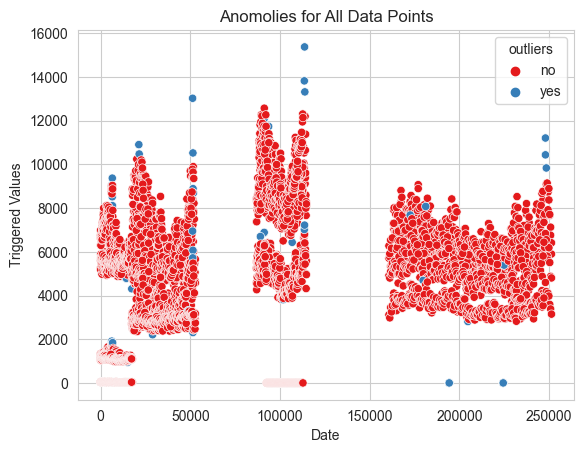

In [ ]:

Y=Finaldf['n_triggered']
X=Finaldf['Index']
Z=Finaldf['outliers']



# Create a scatter plot
# Create a scatter plot with a color palette
sns.set_style("whitegrid")  # Optional: Set the plot style
palette = sns.color_palette("Set1")  # Choose a Seaborn color palette

sns.scatterplot(data=Source,x=X,y=Y,hue=Z, palette=palette)
plt.xlabel("Date")
plt.ylabel("Triggered Values")
plt.title("Anomolies for All Data Points")
plt.show()

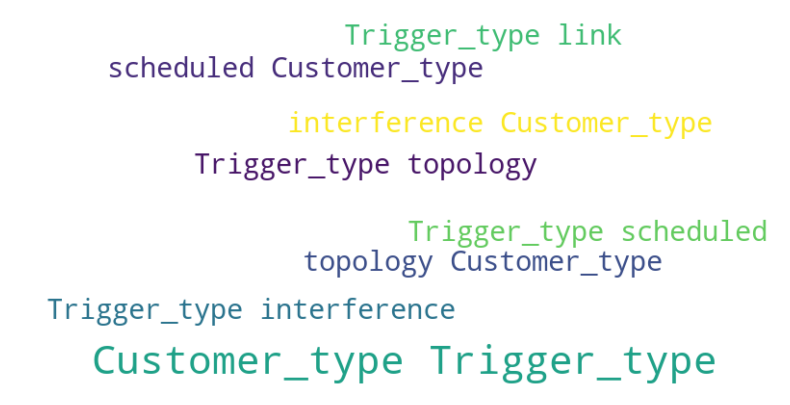

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Combine the text data from the 'text' column into a single string
text_column = Results['Type']  # Replace with the actual column name

# Get the values from the specified column
words = Results['Type'].values

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white',relative_scaling=0.4).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

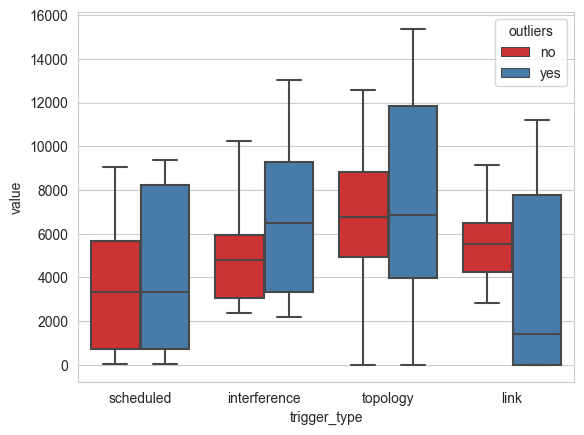

In [ ]:

X = Finaldf['trigger_type']
Z=Finaldf['outliers']
Y=Finaldf['n_triggered']


# Create a scatter plot

# Create a scatter plot with a color palette
sns.set_style("whitegrid")  # Optional: Set the plot style
palette = sns.color_palette("Set1")  # Choose a Seaborn color palette

sns.boxplot(data=Source, x=X,y=Y, hue=Z, palette=palette)
plt.xlabel("trigger_type")
plt.ylabel("value")
plt.legend(title="outliers")
plt.show()



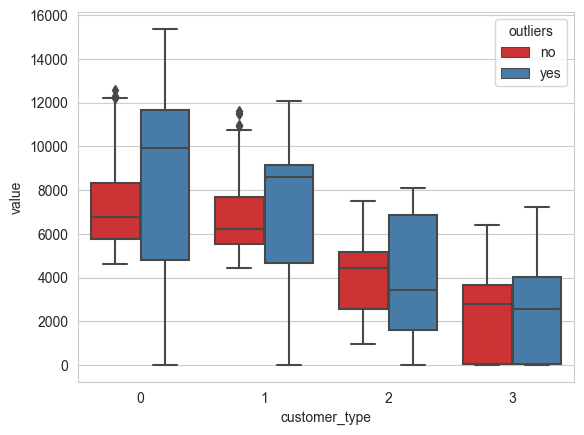

In [ ]:

X = Finaldf['customer_type']
Z=Finaldf['outliers']
Y=Finaldf['n_triggered']


# Create a scatter plot

# Create a scatter plot with a color palette
sns.set_style("whitegrid")  # Optional: Set the plot style
palette = sns.color_palette("Set1")  # Choose a Seaborn color palette

sns.boxplot(data=Source, x=X,y=Y, hue=Z, palette=palette)
plt.xlabel('customer_type')
plt.ylabel("value")
plt.legend(title="outliers")
plt.show()



/var/folders/6y/6hsqd4ts2n3cjf9tpct0b36h0000gp/T/ipykernel_52011/1814001585.py:13: UserWarning:

The palette list has more values (9) than needed (2), which may not be intended.

/Users/rohit.jishtu/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

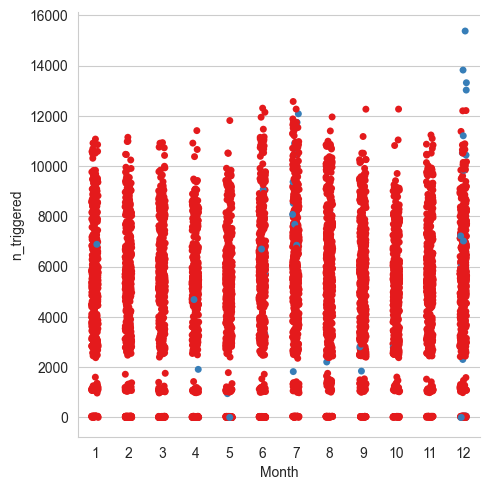

In [ ]:
# Which Month has maximum Outliers 

X = Finaldf['Month']
Z=Finaldf['outliers']
Y=Finaldf['n_triggered']



# Create a scatter plot with a color palette
sns.set_style("whitegrid")  # Optional: Set the plot style
palette = sns.color_palette("Set1")  # Choose a Seaborn color palette

sns.catplot(data=Source, x=X,y=Y, hue=Z, palette=palette)
plt.xlabel("Date")
plt.ylabel("value")
plt.title("Bivariate")
plt.legend(title="outliers")
plt.tight_layout()
plt.show()

# Functions Block

In [25]:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numericsflots = ['float16', 'float32', 'float64']
nonnumerics =['object']
date=['datetime64[ns]','datetime64']
nonnumericsAnddate=['object','datetime64[ns]']

def CalBasicStats(Source_DF,type):
    data = Source_DF
    newdf = pd.DataFrame()
    Resultdf= pd.DataFrame()

    if type=='numeric':
        Traversedf = data.select_dtypes(include=numerics)

        for i in Traversedf.columns:
            
        
        #newdf['DataSourceName']=[name]
            newdf['ColumnName']=[i]

            newdf['AllCounts'] = Traversedf[i].size
            newdf['NotNullCounts'] = Traversedf[i].count()
            newdf['UniqueCounts'] = Traversedf[i].nunique()
            
            newdf["%Zero"] = ((Traversedf[i] == 0).sum()/Traversedf[i].size)*100
            newdf["%Missing"]= 100-(Traversedf[i].count() / Traversedf[i].size)*100

            
            newdf['Min']=np.amin(Traversedf[i])
            newdf['Max']=np.amax(Traversedf[i])
            newdf['Mean']=np.mean(Traversedf[i])

            newdf['Average']=np.average(Traversedf[i])

            newdf['Median']=np.nanmedian(Traversedf[i],axis=0)
            newdf['StddDev']=np.std(Traversedf[i],axis=0)
            newdf['Var']=np.var(Traversedf[i],axis=0)

            newdf['Skewness']=skew(Traversedf[i].dropna())

            newdf['Kurtosis']=kurtosis(Traversedf[i].dropna())
    
            newdf['25Percentile'] = np.nanpercentile(Traversedf[i], 25,axis=0)
            newdf['50Percentile'] = np.nanpercentile(Traversedf[i], 50,axis=0)
            newdf['75Percentile'] = np.nanpercentile(Traversedf[i], 75,axis=0)
            
            
            # Resultdf=Resultdf.append(newdf)
            Resultdf=pd.concat((Resultdf, newdf), axis = 0)
        #newdf["UniueRecords"]=pd.count(Traversedf[i])
        return Resultdf

    else:
        Traversedf = data.select_dtypes(include=nonnumerics) 

        for i in Traversedf.columns:
                # print(i)
        #newdf['DataSourceName']=[name]
            newdf['ColumnName']=[i]
            newdf['AllCounts'] = Traversedf[i].size
            newdf['NotNullCounts'] = Traversedf[i].count()
            newdf['UniqueCounts'] = Traversedf[i].nunique()

            newdf["%Missing"]= 100-(Traversedf[i].count() / Traversedf[i].size)*100

            Resultdf=pd.concat((Resultdf, newdf), axis = 0)     

        return Resultdf